# Reading and plotting WRF data using wrf-python and Xarray

* wrf-python (https://wrf-python.readthedocs.io/en/latest/)
* Once the WRF data is in an Xarray DataArray there are additional tools you can use to process the data (http://xarray.pydata.org/en/stable/)

In [1]:
from netCDF4 import Dataset
import wrf
import xarray as xr
import numpy as np

import cartopy.crs as crs

import matplotlib
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import cartopy.feature as cfe

%matplotlib inline

### Getting started - simply reading a variable from a wrfout file and producing a quick plot

In [2]:
root_dir = '/data/fiss_aic/WRF/runA_2010'
nc = Dataset(root_dir+'/wrfout_d02_2010-03-18_00:00:00')
# t2 = wrf.getvar(nc, 'T2', timeidx=wrf.ALL_TIMES)
t2 = wrf.getvar(nc, 'T2', timeidx=2) # extract 3rd time instance (t=2) - slow....
t2

<xarray.DataArray 'T2' (south_north: 201, west_east: 147)>
array([[245.5202 , 245.26236, 245.24707, ..., 222.38908, 221.92421, 221.39389],
       [244.88438, 244.30995, 244.07245, ..., 222.51459, 222.09602, 221.68324],
       [244.3348 , 243.89217, 243.62329, ..., 222.74355, 222.32124, 221.93173],
       ...,
       [274.37607, 274.21396, 274.08795, ..., 272.44116, 272.42374, 272.40744],
       [274.41467, 274.26974, 274.14963, ..., 272.53183, 272.51157, 272.48935],
       [274.47107, 274.3663 , 274.2573 , ..., 272.62482, 272.60464, 272.5752 ]],
      dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -123.254684 ... -28.57109
    XLAT     (south_north, west_east) float32 -78.73641 -78.8672 ... -60.162468
    XTIME    float32 120.0
    Time     datetime64[ns] 2010-03-18T02:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:      
    coo

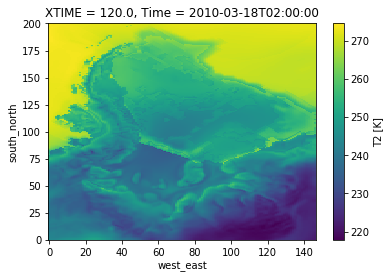

In [3]:
# Quick Plot to check all is well
t2.plot()

# see below for manually setting up your plots

### Contour Plots

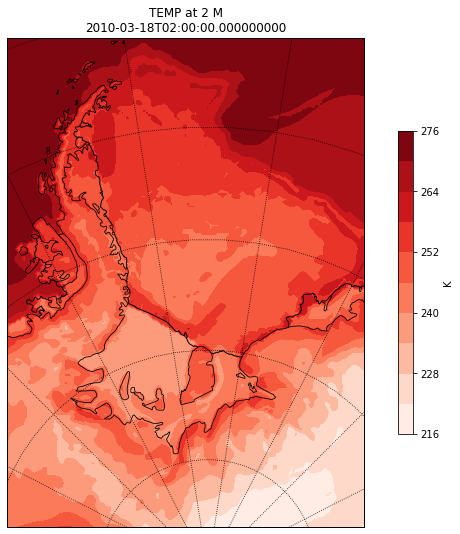

In [5]:
# select one time instance if you have retrieved ALL_TIMES
# t2 = t2.isel(Time=1)

# Get the latitude and longitude points (use original data, rather than any processed data)
lats, lons = wrf.latlon_coords(t2)

# Get the cartopy mapping object (use original data, rather than any processed data)
cart_proj = wrf.get_cartopy(t2)

# Create a figure
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Add coastlines
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', 
                                       '50m', linewidth=1.0, edgecolor='k', facecolor='none') )

# Plot contours
plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(t2), 10, 
                transform=crs.PlateCarree(), cmap=get_cmap("Reds"))

# Add a color bar
cbar = plt.colorbar(ax=ax, shrink=.62)
cbar.set_label(t2.units)

# Set the map limits.  Not really necessary, but used for demonstration.
ax.set_xlim(wrf.cartopy_xlim(t2))
ax.set_ylim(wrf.cartopy_ylim(t2))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(t2.description+'\n'+str(t2.Time.values))

print('')

### Wind Vectors Plots 

WARNING: These can be tricky to correctly produce as the U/V vectors related to the WRF grid, where as we want to plot vectors on a lon/lat grid 

It is always worth checking that what you produce is sensible, e.g., by visually comparing to ERA-Interim

In [8]:
u10 = wrf.getvar(nc, 'U10', timeidx=2)
v10 = wrf.getvar(nc, 'V10', timeidx=2)

nx = nc.dimensions['west_east'].size
ny = nc.dimensions['south_north'].size
dt, dx, dy = nc.DT, nc.DX, nc.DY
cen_lat, cen_lon = nc.CEN_LAT, nc.CEN_LON
truelat1, truelat2, STAND_LON = nc.TRUELAT1, nc.TRUELAT2, nc.STAND_LON
pole_lat, pole_lon = nc.POLE_LAT, nc.POLE_LON

### Create earth-rotated Dataset
# https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.uvmet.html
cone = 1 # ???
uv   = wrf.uvmet(u10, v10, u10.XLONG, u10.XLAT, 
                     cen_lon, cone, meta=True, units='m s-1')

uv

<xarray.DataArray 'uvmet' (u_v: 2, south_north: 201, west_east: 147)>
array([[[  2.239094,   2.302225, ..., -12.55818 , -12.089126],
        [  2.291526,   2.378221, ..., -12.788332, -12.442628],
        ...,
        [ -1.114753,  -1.400135, ...,  -6.202898,  -5.938962],
        [ -1.45267 ,  -1.797253, ...,  -6.033195,  -5.793626]],

       [[ -9.118709,  -9.118726, ...,  -3.944864,  -3.652274],
        [ -9.197542,  -9.128673, ...,  -4.285994,  -3.985036],
        ...,
        [  6.791636,   6.390002, ...,  -4.919767,  -4.815777],
        [  6.969695,   6.530435, ...,  -5.209907,  -5.115947]]], dtype=float32)
Coordinates:
  * u_v      (u_v) <U1 'u' 'v'
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    description:  earth rotated u,v

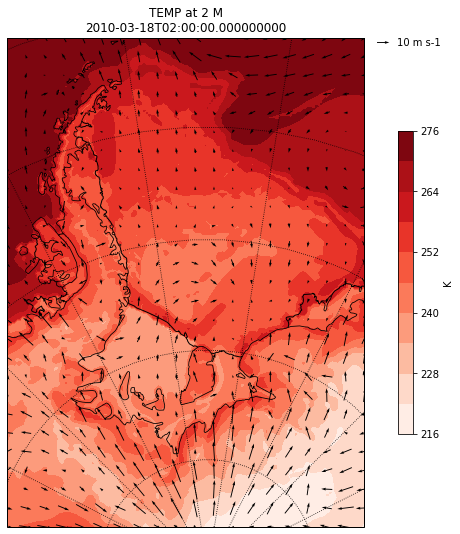

In [10]:
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
cart_proj = wrf.get_cartopy(t2)
ax = plt.axes(projection=cart_proj)

# Add coastlines
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m', 
                                           linewidth=1.0, edgecolor='k', facecolor='none'))

# Plot the wind speed as a contour plot
plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(t2), 10, 
                transform=crs.PlateCarree(), cmap=get_cmap("Reds"))

# Add a color bar
cbar = plt.colorbar(ax=ax, shrink=.62)
cbar.set_label(t2.units)

# Set the map limits.  Not really necessary, but used for demonstration.
ax.set_xlim(wrf.cartopy_xlim(t2))
ax.set_ylim(wrf.cartopy_ylim(t2))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(t2.description+'\n'+str(t2.Time.values))

# Add arrows to show the wind vectors !!!!
x = u10.XLONG.values
y = u10.XLAT.values
u = uv[0].values
v = uv[1].values

Q = plt.quiver( x, y, u, v, 
               pivot='middle', 
               transform=crs.PlateCarree(), 
               regrid_shape=20 
               )

### plot quiver key
qk = plt.quiverkey(Q, 
                   1.07, 0.99,                  # x,y label position
                   10, str(10)+' '+u10.units, # choose units + update string
                   labelpos='E',                # add label to the right
                   coordinates='axes'
                   )